In [1]:
import sys
import SimpleITK as sitk
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline 
import numpy as np
import os
import fnmatch
import shutil
from ipywidgets import interact, fixed
import pandas as pd
import warnings
from skimage import exposure
import _pickle as cPickle

def myshow(image_arr,slice_n):
    plt.imshow(image_arr[slice_n,:,:],cmap='gray')
    plt.show()

In [2]:
'''
Starting Data Augmentation 

We know from the EDA that ~250 images from each modalities had shown no cancer after biopsy

We have ~50 images in each modalities that had shown cancer after biopsy 

So we need to augment these
'''

t2_df = pd.read_csv('./t2_df.csv')
adc_df = pd.read_csv('./adc_df.csv')
bval_df = pd.read_csv('./adc_df.csv')
ktrans_df = pd.read_csv('./ktrans_df.csv')

#assigning names for dataframes

t2_df.name = 't2'
adc_df.name = 'adc'
bval_df.name = 'bval'
ktrans_df.name = 'ktrans'

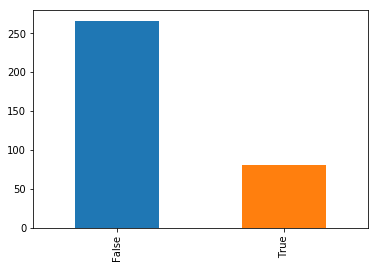

In [3]:
a = t2_df['ClinSig'].value_counts()
a.plot(kind='bar', style='seaborn')

In [4]:
def describe_df(data, column, what_describe = ''):
    
    print('{} for {}\n'.format(what_describe, data.name))
    print(data.loc[:,column].value_counts(), '\n\n\n')
    

frames = [t2_df, adc_df, bval_df, ktrans_df]


#describe biopsy findings 

for i in frames:
    describe_df(i, 'ClinSig', 'Cancer or Not')
    
#describe location from which biopsy was taken     
for i in frames: 
    describe_df(i, 'zone', 'Location Information')


Cancer or Not for t2

False    266
True      81
Name: ClinSig, dtype: int64 



Cancer or Not for adc

False    247
True      68
Name: ClinSig, dtype: int64 



Cancer or Not for bval

False    247
True      68
Name: ClinSig, dtype: int64 



Cancer or Not for ktrans

False    253
True      73
Name: ClinSig, dtype: int64 



Location Information for t2

PZ    204
TZ     86
AS     56
SV      1
Name: zone, dtype: int64 



Location Information for adc

PZ    184
TZ     80
AS     49
SV      2
Name: zone, dtype: int64 



Location Information for bval

PZ    184
TZ     80
AS     49
SV      2
Name: zone, dtype: int64 



Location Information for ktrans

PZ    192
TZ     83
AS     51
Name: zone, dtype: int64 





In [5]:
#Let`s take a look how many locations do we have among patients with and without cancer 

def take_cancer_nocancer(data, column, cancer=True):
    data_cancer = data.loc[data[column]==cancer]
    return data_cancer


#CANCER 
#t2
data_cancer_t2 = take_cancer_nocancer(t2_df, 'ClinSig')
data_cancer_t2.name = 't2'

#adc 
data_cancer_adc = take_cancer_nocancer(adc_df, 'ClinSig')
data_cancer_adc.name = 'adc'

#bval
data_cancer_bval = take_cancer_nocancer(bval_df, 'ClinSig')
data_cancer_bval.name = 'bval'

#ktrans
data_cancer_ktrans = take_cancer_nocancer(ktrans_df, 'ClinSig')
data_cancer_ktrans.name = 'ktrans'

#No Cancer
data_no_cancer_t2 = take_cancer_nocancer(t2_df, 'ClinSig', cancer=False)
data_no_cancer_t2.name = 't2'

#adc 
data_no_cancer_adc = take_cancer_nocancer(adc_df, 'ClinSig', cancer=False)
data_no_cancer_adc.name = 'adc'

#bval
data_no_cancer_bval = take_cancer_nocancer(bval_df, 'ClinSig', cancer=False)
data_no_cancer_bval.name = 'bval'

#ktrans
data_no_cancer_ktrans = take_cancer_nocancer(ktrans_df, 'ClinSig', cancer=False)
data_no_cancer_ktrans.name = 'ktrans'

cancer_list = [data_cancer_t2,data_cancer_adc,data_cancer_bval, data_cancer_ktrans]
nocancer_list = [data_no_cancer_t2, data_no_cancer_adc, data_no_cancer_bval, data_no_cancer_ktrans]

for i in cancer_list:
    describe_df(i, 'zone', 'Cancer Zones Count')
    
for i in nocancer_list:
    describe_df(i, 'zone', 'Zones Without Cancer Count')

Cancer Zones Count for t2

PZ    40
AS    30
TZ    11
Name: zone, dtype: int64 



Cancer Zones Count for adc

PZ    35
AS    24
TZ     9
Name: zone, dtype: int64 



Cancer Zones Count for bval

PZ    35
AS    24
TZ     9
Name: zone, dtype: int64 



Cancer Zones Count for ktrans

PZ    36
AS    28
TZ     9
Name: zone, dtype: int64 



Zones Without Cancer Count for t2

PZ    164
TZ     75
AS     26
SV      1
Name: zone, dtype: int64 



Zones Without Cancer Count for adc

PZ    149
TZ     71
AS     25
SV      2
Name: zone, dtype: int64 



Zones Without Cancer Count for bval

PZ    149
TZ     71
AS     25
SV      2
Name: zone, dtype: int64 



Zones Without Cancer Count for ktrans

PZ    156
TZ     74
AS     23
Name: zone, dtype: int64 





In [31]:
#function to match all of the image sequences to the dataframe and than save it using pickle, to preserve numpy array
def join_arrays(data, im_seq_path):
    
    array = sitk.GetArrayFromImage(sitk.ReadImage(im_seq_path)) #reading image and converting it to the array
    
    data['image'] = 0 #creting new column for the images 
    
    for i in range(len(data.loc[:, 'ProxID'])):
        
        arr = np.asarray(array[i], object)
        data.at[i, 'image'] =  arr #attaching array to the corresponding ProxID
    
    return data 


def changing(df, what_to_save):
    df = df.loc[:, what_to_save]
    return df         


def write_to_pickle(data, new_names):
    #function to save dataframe with numpy array
    data.to_pickle('./'+new_names)
    
def apply_all_changes_and_save(list_of_frames, list_of_paths, new_names, sign_cols):
    #applying all functions into one through for loop
    for i in range(len(frames)):
        new_df = join_arrays(list_of_frames[i], list_of_paths[i])
        changed_df = changing(new_df, sign_cols)
        write_to_picke(changed_df, new_names)

In [40]:
#reading arrays 
t2_arr = sitk.GetArrayFromImage(sitk.ReadImage('./t2_seq.nii.gz'))
adc_arr = sitk.GetArrayFromImage(sitk.ReadImage('./adc_seq.nii.gz'))
bval_arr = sitk.GetArrayFromImage(sitk.ReadImage('./bval_seq.nii.gz'))
ktrans_arr = sitk.GetArrayFromImage(sitk.ReadImage('./ktrans_seq.nii.gz'))

#function to save the arrays into dataframes
def loop_at_patch(data, array): 
    for i in range(len(data)):
        data.at[i, 'patches'] = array[i]
        return data

#applying function

t2_df=loop_at_patch(t2_df, t2_arr)
adc_df=loop_at_patch(adc_df, adc_arr)
bval_df=loop_at_patch(bval_df, bval_arr)
ktrans_df=loop_at_patch(ktrans_df, ktrans_arr)

In [48]:
#leave only significant columns

def leave_sig(data,columns=['ClinSig', 'patches']):
    data=data.loc[:, columns]
    return data

t2_changed=leave_sig(t2_df)
adc_changed=leave_sig(adc_df)
bval_changed=leave_sig(bval_df)
ktrans_changed=leave_sig(ktrans_df)




In [54]:
#write results to pickle 
def write_to_pickle(data, new_names):
    #function to save dataframe with numpy array
    data.to_pickle('./'+new_names)

    
write_to_pickle(t2_changed, 't2_pickle')
write_to_pickle(adc_changed, 'adc_pickle')
write_to_pickle(bval_changed, 'bval_pickle')
write_to_pickle(ktrans_changed, 'ktrans_pickle')